In [317]:
from langgraph.graph import Graph
from pydantic import BaseModel
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from typing import Optional, TypedDict
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from typing import Union


from fastapi import FastAPI
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
llm=ChatGroq(model="llama3-groq-70b-8192-tool-use-preview")


In [318]:
class InputState(TypedDict):
    user_question:str
    user_answer:str
    gen_context:str
    question_type:str
    subject: Optional[str]
class OutputState(TypedDict):
    feedback:str
    Total_Score:int
    Accuracy: int
    Relevance_to_the_Question:int
    percentage:float
    Logical_Consistency: int
    Scientific_Accuracy: int
    Depth_and_Explanation: int
    Factual_Correctness: int
class OverallState(InputState,OutputState):
    pass


In [319]:
tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    
)
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [ ]:
import datetime

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig, chain

today = datetime.datetime.today().strftime("%D")
prompt = ChatPromptTemplate(
    [
        ("system", f"You are a helpful assistant. The date today is {today}."),
        ("human", "{user_input}"),
        ("placeholder", "{messages}"),
    ]
)

llm_with_tools = llm.bind_tools([tool,wikipedia])

llm_chain = prompt | llm_with_tools


@chain
def tool_chain(state:InputState):
    user_input=state["user_question"]
    input_ = {"user_input": user_input}
    ai_msg = llm_chain.invoke(input_)
    print("ai_msg",ai_msg)
    tool_msgs = tool.batch(ai_msg.tool_calls)
    print("tool_msgs",tool_msgs)
    z=llm_chain.invoke({**input_, "messages": [ai_msg, *tool_msgs]})
    print("toolchain",z)
    return {"gen_context":z}

class subject(BaseModel):
    subject:str
class question_re(BaseModel):
    reformatted_question:str
    
def question_reformat(state: InputState)->InputState:
    prompt = f"""
    You are an assistant that helps to reformat questions. Your task is to rephrase the given question in a clear, structured, and grammatically correct way.

    ### Input:
    - **Original Question**: "{state['user_question']}"

    ### Task:
    Please reformat the question to make it more clear, direct, and formal if necessary. Your output should be a reformatted version of the original question.

    ### Output Format:
    Provide the reformatted question in the following JSON format:
    ```json
    {{
        "reformatted_question": "<Rephrased version of the input question>"
    }}
    ```

    """
    # Invoke the LLM with the prompt
    response_question = llm.invoke(prompt)
    try:
        parsed_response = question_re.parse_raw(response_question.content)  # Parse the JSON response
        print("Parsed subject:", parsed_response.reformatted_question)  # Print parsed subject
        return {"user_question":parsed_response.reformatted_question}
    except Exception as e:
        print(f"Error parsing response: {e}")
        return {"user_question":state["user_question"]}


def subject_checker(state: InputState)->InputState:
    prompt = f"""
You are an intelligent assistant trained to classify questions into specific subject categories. Your task is to analyze the given question and determine the most appropriate subject type based on its content.

### Input:
- **Question**: "{state['user_question']}"

### Subject Categories:
1. **Logical Reasoning**: Questions that involve patterns, puzzles, reasoning, or problem-solving.
   - Examples: "If all cats are animals, and some animals are wild, can all cats be wild?" or "What comes next in the sequence: 2, 4, 8, 16, ...?"

2. **Science**: Questions that relate to scientific concepts, theories, or facts from subjects like Physics, Biology, Chemistry, etc.
   - Examples: "Why does water boil at 100 degrees Celsius?" or "What is the role of mitochondria in a cell?"

3. **General Knowledge**: Questions that involve facts, history, geography, or any general topic outside of logic and science.
   - Examples: "Who is the President of the United States in 2024?" or "Where is the Eiffel Tower located?"

### Task:
Analyze the question and classify it into one of the three categories: Logical Reasoning, Science, or General Knowledge.

### Output Format:
Provide your classification in the following JSON format:
```json
{{
    "subject":"Logical Reasoning / Science / General Knowledge"
}}
"""
    response_subject = llm.invoke(prompt)
    try:
        parsed_response = subject.parse_raw(response_subject.content)  # Parse the JSON response
        print("Parsed subject:", parsed_response.subject)  # Print parsed subject
        return {"subject":parsed_response.subject}
    except Exception as e:
        print(f"Error parsing response: {e}")
        state["subject"] = "Unknown"




In [321]:


# Base Evaluation Output
class BaseEvaluationOutput(BaseModel):
    Total_Score: int
    feedback: str
    percentage: float

# Logical Evaluation Output
class LogicalEvaluationOutput(BaseEvaluationOutput):
    Logical_Consistency: int

# Science Evaluation Output
class ScienceEvaluationOutput(BaseEvaluationOutput):
    Scientific_Accuracy: int
    Depth_and_Explanation: int

# General Knowledge Evaluation Output
class GeneralKnowledgeEvaluationOutput(BaseEvaluationOutput):
    Factual_Correctness: int
    Relevance_to_the_Question: int


In [322]:
def evaluate(state: InputState):
    """Evaluate the question and answer using the generated context with a focus on mathematical accuracy."""

    print("eval",state["subject"])
    if state["subject"]=="Logical Reasoning":
        prompt = f"""
You are an expert evaluator specializing in logical reasoning questions. Your task is to evaluate the user's answer based on the following input details:

- **Question**: "{state['user_question']}"
- **User's Answer**: "{state['user_answer']}"
- **Reference Answer**: "{state['gen_context']}" (if available; otherwise, base your evaluation on logical principles)
- **Question Type**: "{state['question_type']}"

### Evaluation Criteria:
1. **Logical Consistency (10 points)**: Is the user's reasoning consistent and free of logical fallacies?
   - Assign full points if the reasoning is flawless.
   - Deduct points for errors, omissions, or contradictions.


### Scoring Instructions:
- Provide a score for each criterion out of 10.
- Calculate the total score out of 20 by summing the individual scores.
- Calculate the percentage as `(Total Score / 20) * 100` and round it to two decimal places.

### Feedback:
Provide constructive feedback that highlights strengths and areas of improvement in the user's reasoning.

### Output Format:
Provide your evaluation strictly in the following JSON format:
```json
{{
    "Logical_Consistency": (integer between 0-10),
    "Total_Score": (integer between 0-20),
    "percentage": (float rounded to two decimal places),
    "feedback": "Constructive feedback focusing on logical reasoning."
}}
"""
        response_model = LogicalEvaluationOutput

    elif state['subject'] in ['Science', 'Physics', 'Biology']:
        prompt = f"""
You are an expert evaluator specializing in scientific subjects. Your task is to evaluate the user's answer to a scientific question based on the following input details:

- **Question**: "{state['user_question']}"
- **User's Answer**: "{state['user_answer']}"
- **Reference Answer**: "{state['gen_context']}" (if available; otherwise, use scientific principles to evaluate)
- **Question Type**: "{state['question_type']}"

### Evaluation Criteria:
1. **Scientific Accuracy (10 points)**: Does the user's answer align with established scientific principles?
   - Assign full points for scientifically accurate and well-explained answers.
   - Deduct points for inaccuracies or omissions.
2. **Depth and Explanation (10 points)**: Does the user's answer demonstrate a good understanding of the topic and provide sufficient detail?
   - Assign full points for thorough and well-articulated answers.
   - Deduct points for incomplete or poorly explained answers.

### Scoring Instructions:
- Provide a score for each criterion out of 10.
- Calculate the total score out of 20 by summing the individual scores.
- Calculate the percentage as `(Total Score / 20) * 100` and round it to two decimal places.

### Feedback:
Provide constructive feedback that highlights strengths and areas of improvement, such as missing scientific details or logical inconsistencies.

### Output Format:
Provide your evaluation strictly in the following JSON format:
```json
{{
    "Scientific_Accuracy": (integer between 0-10),
    "Depth_and_Explanation": (integer between 0-10),
    "Total_Score": (integer between 0-20),
    "percentage": (float rounded to two decimal places),
    "feedback": "Constructive feedback focusing on scientific accuracy and depth."
}}
"""
        response_model = ScienceEvaluationOutput

    else:
        print(state["subject"])
        prompt = f"""
You are an expert evaluator specializing in general knowledge and miscellaneous subjects. Your task is to evaluate the user's answer based on the following input details:

- **Question**: "{state['user_question']}"
- **User's Answer**: "{state['user_answer']}"
- **Reference Answer**: "{state['gen_context']}" (if available; otherwise, base your evaluation on standard knowledge)
- **Question Type**: "{state['question_type']}"

### Evaluation Criteria:
1. **Factual Correctness (10 points)**: Is the user's answer factually accurate?
   - Assign full points for correct and precise answers.
   - Deduct points for inaccuracies or incorrect information.
2. **Relevance to the Question (10 points)**: Does the user's answer address the question directly and concisely?
   - Assign full points for relevant and well-focused answers.
   - Deduct points for irrelevant or vague answers.

### Scoring Instructions:
- Provide a score for each criterion out of 10.
- Calculate the total score out of 20 by summing the individual scores.
- Calculate the percentage as `(Total Score / 20) * 100` and round it to two decimal places.

### Feedback:
Provide constructive feedback that highlights areas of improvement, such as factual errors or lack of clarity.

### Output Format:
Provide your evaluation strictly in the following JSON format:
```json
{{
    "Factual_Correctness": (integer between 0-10),
    "Relevance_to_the_Question": (integer between 0-10),
    "Total_Score": (integer between 0-20),
    "percentage": (float rounded to two decimal places),
    "feedback": "Constructive feedback focusing on factual correctness and relevance."
}}
"""
        response_model = GeneralKnowledgeEvaluationOutput

    
    response = llm.invoke(prompt)
    try:
        parsed_response = response_model.parse_raw(response.content)
        return parsed_response.dict()
    except Exception as e:
        print("Error parsing response:", e)
        return {
            "marks": 0,
            "feedback": "Unable to parse response. Please ensure the format is correct.",
        }


In [ ]:
builder=StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node("tailvy_tool",tool_chain)
builder.add_node("evalulate",evaluate)
builder.add_node("question_reformat",question_reformat)
builder.add_node("subject_finder",subject_checker)
builder.add_edge(START,"question_reformat")
builder.add_edge("question_reformat","subject_finder")
builder.add_edge("subject_finder","tailvy_tool")
builder.add_edge("tailvy_tool","evalulate")
builder.add_edge("evalulate",END)
graph=builder.compile()


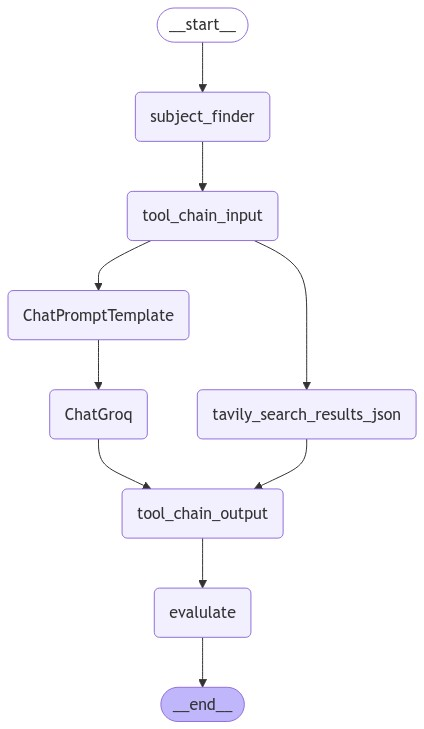

In [324]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [325]:
data=graph.invoke({"user_question":"solve 2*4+9?","user_answer":"it is 8+9","gen_context":"None","question_type":"Short","subject":"None"})

Parsed subject: Logical Reasoning
ai_msg content="To solve the expression 2*4+9, we need to follow the order of operations (PEMDAS/BODMAS), which states that multiplication should be done before addition. So, first, let's calculate the multiplication:\n\n2*4 = 8\n\nNow, add the result to 9:\n\n8 + 9 = 17\n\nSo, the solution to the expression 2*4+9 is 17." additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 356, 'total_tokens': 445, 'completion_time': 0.283104618, 'prompt_time': 0.025079646, 'queue_time': 0.008040089999999996, 'total_time': 0.308184264}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'stop', 'logprobs': None} id='run-6f93ed62-c1d7-4fbd-aa7d-0f45d5d040ec-0' usage_metadata={'input_tokens': 356, 'output_tokens': 89, 'total_tokens': 445}
tool_msgs []
toolchain content='' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens':

In [326]:
data


{'feedback': "The user's reasoning is flawless and demonstrates a clear understanding of the mathematical operation.",
 'Total_Score': 20,
 'percentage': 100.0,
 'Logical_Consistency': 10}

In [327]:
import nest_asyncio
import uvicorn
import subprocess
from fastapi.responses import JSONResponse
from fastapi import FastAPI, HTTPException, status


In [328]:

app = FastAPI()
class Item(BaseModel):
    user_question: str
    user_answer: str
    question_type: str =None

@app.post("/evaluate")
def evaluate(item: Item):
    data=graph.invoke({"user_question":item.user_question,"user_answer":item.user_answer,"gen_context:str":"None","question_type":item.question_type})
    # feedback=data["feedback"]
    # marks=data["marks"]
    # factual_accuracy=data["factual_accuracy"]
    # completeness=data["completeness"]
    # errors=data["errors"]
    # percentage=data["percentage"]
    return JSONResponse(
        content={"message": "Item created successfully", "data": data},
        status_code=status.HTTP_201_CREATED  # HTTP 201 Created
    )

In [329]:


class Item(BaseModel):
    name: str
    description: str
    price: float
    tax: float = None

@app.post("/create_item")
def create_item(item: Item):
    # Example of using the status code for 'Created' (201)
    print(item.name)
    return JSONResponse(
        content={"message": "Item created successfully", "item": item.dict(),"name":item.name},
        status_code=status.HTTP_201_CREATED  # HTTP 201 Created
    )

In [330]:
import asyncio
import uvicorn

async def serve():
    config = uvicorn.Config(app, host="127.0.0.1", port=8001)
    server = uvicorn.Server(config)
    await server.serve()

asyncio.run(serve())

RuntimeError: asyncio.run() cannot be called from a running event loop